In this notebook we aim to (numerically) solve the N-spring-pendulum and explore what comes of it. 

To begin with, let us get preliminaries out of the way. This solution will use Cartesian coordinates for each of the masses. The advantage of this choice of coordinates is that it will lead to a remarkably simple expression of the kinetic and potential energies (as we will see shortly), though of course it is not as intuitive as polar coordinates. But no matter; once I have retrieved the solutions, I will convert them back to polar coordinates to see if there are any clearer conclusions to be made. Note that what I mean by polar coordinates is the polar coordinate of each mass with respect to the mass before it, not with respect to the origin. 

Anyway, let's start with the Lagrangian. The kinetic energy is utterly trivial:

\begin{align}
    T = \sum_i \frac{1}{2}m_i\left(\dot x_i^2 + \dot y_i^2\right)
\end{align}

The potential energy is a little more tedious, but is nevertheless straightforward:

\begin{align}
    U = \sum_i mgy_i + \frac{1}{2}\sum_{i=2}^N k_i\biggl\{\sqrt{\left(x_i-x_{i-1}\right)^2 + \left(y_i-y_{i-1}\right)^2} - l_i\biggl\}^2 + \frac{1}{2}k_1\left(\sqrt{x_1^2+y_1^2}-l_1\right)^2
\end{align}

The first term is merely the gravitational potential, which also takes this extremely simple form because of the choice of coordinates, and the rest are just the spring energies. Note that the first mass is treated as a special case because there is no "previous mass" to work off of. Note that the spring energies have a much more elegant form in polar coordinates, since each extension would just be $r_i$. However, the kinetic energies would be forbiddingly complicated. Indeed, we'd have to define the position of each mass with respect to the previous mass, and then calculate the derivative of these coordinates, and then square them. Maybe it's possible, but this is not a journey I'd want to embark in.

From here the E-L equations are rather straightforward, for T has no position dependence, and of course U has no dependence on the generalized velocities. The sort of tricky aspect of taking the velocity derivative of T is in noticing that each x-coordinate actually shows up twice in the sum, except for the last mass. The first mass shows up once in the sum, and once in the term outside the sum for the springs. The same story holds for the y-coordinates, but they will have the additional gravitational term. Keeping this in mind the equations of motion are (after some simplification):

\begin{gather}
    m_i\ddot x_i = k_{i+1}(x_{i+1} - x_i)\left(1-\frac{l_{i+1}}{\sqrt{\left(x_{i+1}-x_i\right)^2 + \left(y_{i+1}-y_i\right)^2}}\right) - k_i(x_i - x_{i-1})\left(1-\frac{l_i}{\sqrt{\left(x_i-x_{i-1}\right)^2 + \left(y_i-y_{i-1}\right)^2}}\right) \\[1cm]

    m_i\ddot y_i = -m_ig + k_{i+1}(y_{i+1} - y_i)\left(1-\frac{l_{i+1}}{\sqrt{\left(x_{i+1}-x_i\right)^2 + \left(y_{i+1}-y_i\right)^2}}\right) - k_i(y_i - y_{i-1})\left(1-\frac{l_i}{\sqrt{\left(x_i-x_{i-1}\right)^2 + \left(y_i-y_{i-1}\right)^2}}\right) \\[0.3cm]
\end{gather}

This is the general i-th case. In the case of the first mass, the "previous" positions in the negative spring term are just replaced with zero, and for the last mass, the positive spring term just vanishes because there is no "next mass". 

We are now ready to get started on the coding portion. To begin with, the necessary imports. 

In [226]:
%matplotlib inline

In [227]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

Here I will copy over the NSP class just to make sure this notebook can act as a standalone document. 

In [228]:
class NSP():
    """
    This class models an N-pendulum system with springs instead of rods (minimum N is 2).
     
    Parameters
    ----------
    M : vector of floats
        the masses that make up the N-pendulum
    K : vector of floats
        the spring constants of the springs in between the masses
    L : vector of floats
        the equilibrium lengths if the springs in between the masses

    Methods
    -------
    dy_dt(y, t)
        Returns the right side of the differential equation in vector y, 
        given time t and the corresponding value of y.
    """
    def __init__(self, M, K, L):
        self.M = M
        self.K = K
        self.L = L
    
    def dy_dt(self, t, y):
        g = 20
        derivative = np.zeros(len(y))
        half_index = int(len(y)/2)
        y_index = int(half_index/2)

        derivative[:half_index] = y[half_index:]

        spr_len_1 = np.sqrt(y[0]**2 + y[y_index]**2)
        spr_len_2 = np.sqrt((y[1]-y[0])**2 + (y[y_index + 1]-y[y_index])**2)

        derivative[half_index] = (self.K[1]/self.M[0])*(y[1]-y[0])*(1-(self.L[1]/spr_len_2)) \
                                            - (self.K[0]/self.M[0])*y[0]*(1-self.L[0]/spr_len_1)
        
        derivative[half_index + y_index] = -g + (self.K[1]/self.M[0])*(y[y_index+1]-y[y_index]) \
                                            *(1-(self.L[1]/spr_len_2)) - (self.K[0]/self.M[0]) \
                                            *y[y_index]*(1-self.L[0]/spr_len_1)
        for i in range(1, y_index - 1):
            spr_len_1 = np.sqrt((y[i]-y[i-1])**2 + (y[y_index+i]-y[y_index+i-1])**2)
            spr_len_2 = np.sqrt((y[i+1]-y[i])**2 + (y[y_index+i+1]-y[y_index+i])**2)

            derivative[half_index + i] = (self.K[i+1]/self.M[i])*(y[i+1]-y[i])*(1-(self.L[i+1]/spr_len_2)) \
                                                - (self.K[i]/self.M[i])*(y[i]-y[i-1])*(1-self.L[i]/spr_len_1)
            
            derivative[half_index + y_index + i] = -g + (self.K[i+1]/self.M[i])*(y[y_index+i+1]-y[y_index+i]) \
                                                *(1-(self.L[i+1]/spr_len_2)) - (self.K[i]/self.M[i]) \
                                                *(y[y_index + i] - y[y_index+i-1])*(1-self.L[i]/spr_len_1)
        
        spr_len_1 = np.sqrt((y[y_index-1]-y[y_index-2])**2 + (y[half_index-1]-y[half_index-2])**2)

        derivative[half_index+y_index-1] = -(self.K[-1]/self.M[-1])*(y[y_index-1]-y[y_index-2])*(1-self.L[-1]/spr_len_1)
        
        derivative[-1] = -g - (self.K[-1]/self.M[-1])*(y[half_index-1]-y[half_index-2])*(1-self.L[-1]/spr_len_1)
                                                                        
        return derivative
    
    def solve_ode(self, x_0, y_0, x_dot_0, y_dot_0, t_pts, method='RK45', abserr=1.0e-10, relerr=1.0e-10):
        y = np.concatenate((x_0, y_0, x_dot_0, y_dot_0))
        solution = solve_ivp(self.dy_dt, (t_pts[0], t_pts[-1]), 
                             y, t_eval=t_pts, method=method, 
                             atol=abserr, rtol=relerr)
        return solution.y

I would also like to create a function here that will simplify plotting the state space orbits, given the solution matrix from solve_ivp. Here, as promised, I'll also calculate the polar coordinates and see if anything interesting happens.

In [229]:
def plot_state_spaces(solution_matrix, fig, lw):
    rows, cols = solution_matrix.shape

    index = int(rows/4)
    for i in range(index):

        x = solution_matrix[i, :]
        x_prev = np.zeros_like(x)            
        xd = solution_matrix[i+2*index, :]
        x_prev_d = np.zeros_like(xd)

        y = solution_matrix[i+index, :]
        y_prev = np.zeros_like(y)  
        yd = solution_matrix[i+index+2*index, :]
        y_prev_d = np.zeros_like(yd)

        if (i != 0):
            x_prev = solution_matrix[i-1, :]
            y_prev = solution_matrix[i+index-1, :]
            x_prev_d = solution_matrix[i+2*index-1, :]
            y_prev_d = solution_matrix[i+index+2*index-1, :]

        delta_x = x-x_prev
        delta_y = y-y_prev
        delta_xd = xd - x_prev_d
        delta_yd = yd - y_prev_d
        
        r = np.sqrt(delta_x**2 + delta_y**2)
        rd = (delta_x*delta_xd + delta_y*delta_yd)/r
        
        theta = np.arctan2(delta_x, -delta_y)
        thetad = (delta_x*delta_yd - delta_y*delta_xd)/(delta_y**2+delta_x**2)

        ax1 = fig.add_subplot(index, 4, 4*i+1)
        ax1.plot(x, xd, lw=lw)
        ax1.set_title(rf'State Space for $x_{i+1}$', fontsize=15)
        ax1.set_xlabel(rf'$x_{i+1}$', fontsize=15)
        ax1.set_ylabel(rf'$\dot x_{i+1}$', fontsize=15)

        ax2 = fig.add_subplot(index, 4, 4*i+2)
        ax2.plot(y, yd, lw=lw)
        ax2.set_title(rf'State Space for $y_{i+1}$', fontsize=15)
        ax2.set_xlabel(rf'$y_{i+1}$', fontsize=15)
        ax2.set_ylabel(rf'$\dot y_{i+1}$', fontsize=15)

        ax3 = fig.add_subplot(index, 4, 4*i+3)
        ax3.plot(r, rd, lw=lw)
        ax3.set_title(rf'State Space for $r_{i+1}$', fontsize=15)
        ax3.set_xlabel(rf'$r_{i+1}$', fontsize=15)
        ax3.set_ylabel(rf'$\dot r_{i+1}$', fontsize=15)

        ax4 = fig.add_subplot(index, 4, 4*i+4)
        ax4.plot(theta, thetad, lw=lw)
        ax4.set_title(rf'State Space for $\theta_{i+1}$', fontsize=15)
        ax4.set_xlabel(rf'$\theta_{i+1}$', fontsize=15)
        ax4.set_ylabel(rf'$\dot\theta_{i+1}$', fontsize=15)

        fig.tight_layout()

As far as the vector field plot goes, in this system the second derivatives depend on multiple different generalized coordinates. To create a streamplot I'd have to create a meshgrid of the generalized coordinate and its corresponding velocity, and to that extent I'd need the derivative of the velocity as well. This is a tricky thing to do here, since that derivative depends on other coordinates. Of course, I could always just hold the "other" coordinates at some constant value, but such a streamplot has little to no use since it doesn't really faithfully display the time evolution of the system. The whole idea of "tracing a trajectory" would make no sense, since as we trace along the other coordinates change, which produces an entirely different streamplot.

Nevertheless, it's a part of the project description so I'll just do all the vector field plots for the four coordinates in the N = 2 case with the other coordinates held at some fixed value. Again though, I want to reiterate this is just for demonstration purposes, and I don't really think any meaningful conclusions can be extracted from it--though, depending on the fixed values, we may be able to discern if the plot makes sense. I'll create a similar function to the above one just to keep things somewhat organized. 

For the fixed values I'm just going to say the other masses are lined up in a 45 degree line from the pivot going down right. The velocities won't matter, but I suppose we can just imagine they're stationary.

In [230]:
def streamplot_state_spaces(spr_object, fig):
    g = 9.8
    N = len(spr_object.M)
    for i in range(N):
        w=40
        xd, x = np.mgrid[-w:w:100j, -w:w:100j]
        x_prev = np.zeros_like(x) + i
        x_next = np.zeros_like(x) + i + 2           

        yd, y = np.mgrid[-w:w:100j, -w:w:100j]
        y_prev = np.zeros_like(y) - i
        y_next = np.zeros_like(y) - i - 2

        if (i == 0):
            x_prev = np.zeros_like(x)
            y_prev = np.zeros_like(y)

        spr_len_1 = np.sqrt((x-x_prev)**2 + (y-y_prev)**2)
        spr_len_2 = np.sqrt((x_next-x)**2 + (y_next-y)**2)
        if (i != N-1):
            xdd = (spr_object.K[i+1]/spr_object.M[i])*(x_next-x)*(1-(spr_object.L[i+1]/spr_len_2)) \
                                                - (spr_object.K[i]/spr_object.M[i])*(x-x_prev)*(1-spr_object.L[i]/spr_len_1)
            
            ydd = -g + (spr_object.K[i+1]/spr_object.M[i])*(y_next-y) \
                                                *(1-(spr_object.L[i+1]/spr_len_2)) - (spr_object.K[i]/spr_object.M[i]) \
                                                *(y-y_prev)*(1-spr_object.L[i]/spr_len_1)
        else:
            xdd = - (spr_object.K[i]/spr_object.M[i])*(x-x_prev)*(1-spr_object.L[i]/spr_len_1)
            
            ydd = -g - (spr_object.K[i]/spr_object.M[i]) *(y-y_prev)*(1-spr_object.L[i]/spr_len_1)

        ax1 = fig.add_subplot(N, 2, 2*i+1)
        ax1.streamplot(x, xd, xd, xdd, density=3)
        ax1.set_title(rf'State Space for $x_{i+1}$', fontsize=15)
        ax1.set_xlabel(rf'$x_{i+1}$', fontsize=15)
        ax1.set_ylabel(rf'$\dot x_{i+1}$', fontsize=15)
        ax1.set_xlim(-10, 10)

        ax2 = fig.add_subplot(N, 2, 2*i+2)
        ax2.streamplot(y, yd, yd, ydd, density=3)
        ax2.set_title(rf'State Space for $y_{i+1}$', fontsize=15)
        ax2.set_xlabel(rf'$y_{i+1}$', fontsize=15)
        ax2.set_ylabel(rf'$\dot y_{i+1}$', fontsize=15)
        ax2.set_xlim(-10, 10)


        fig.tight_layout()

In [231]:
N = 2
M_vec = np.zeros(N) + 10
K_vec = np.zeros(N) + 500
L_vec = np.zeros(N) + 1
spring_pendulum = NSP(M_vec, K_vec, L_vec)

x_0 = [i for i in range(1, N+1)]
y_0=[-i for i in range(1, N+1)] 
x_dot_0 = np.zeros(N)
y_dot_0 = np.zeros(N)
t_pts = np.arange(0, 100, 0.001)

#solution = spring_pendulum.solve_ode(x_0, y_0, x_dot_0, y_dot_0, t_pts)


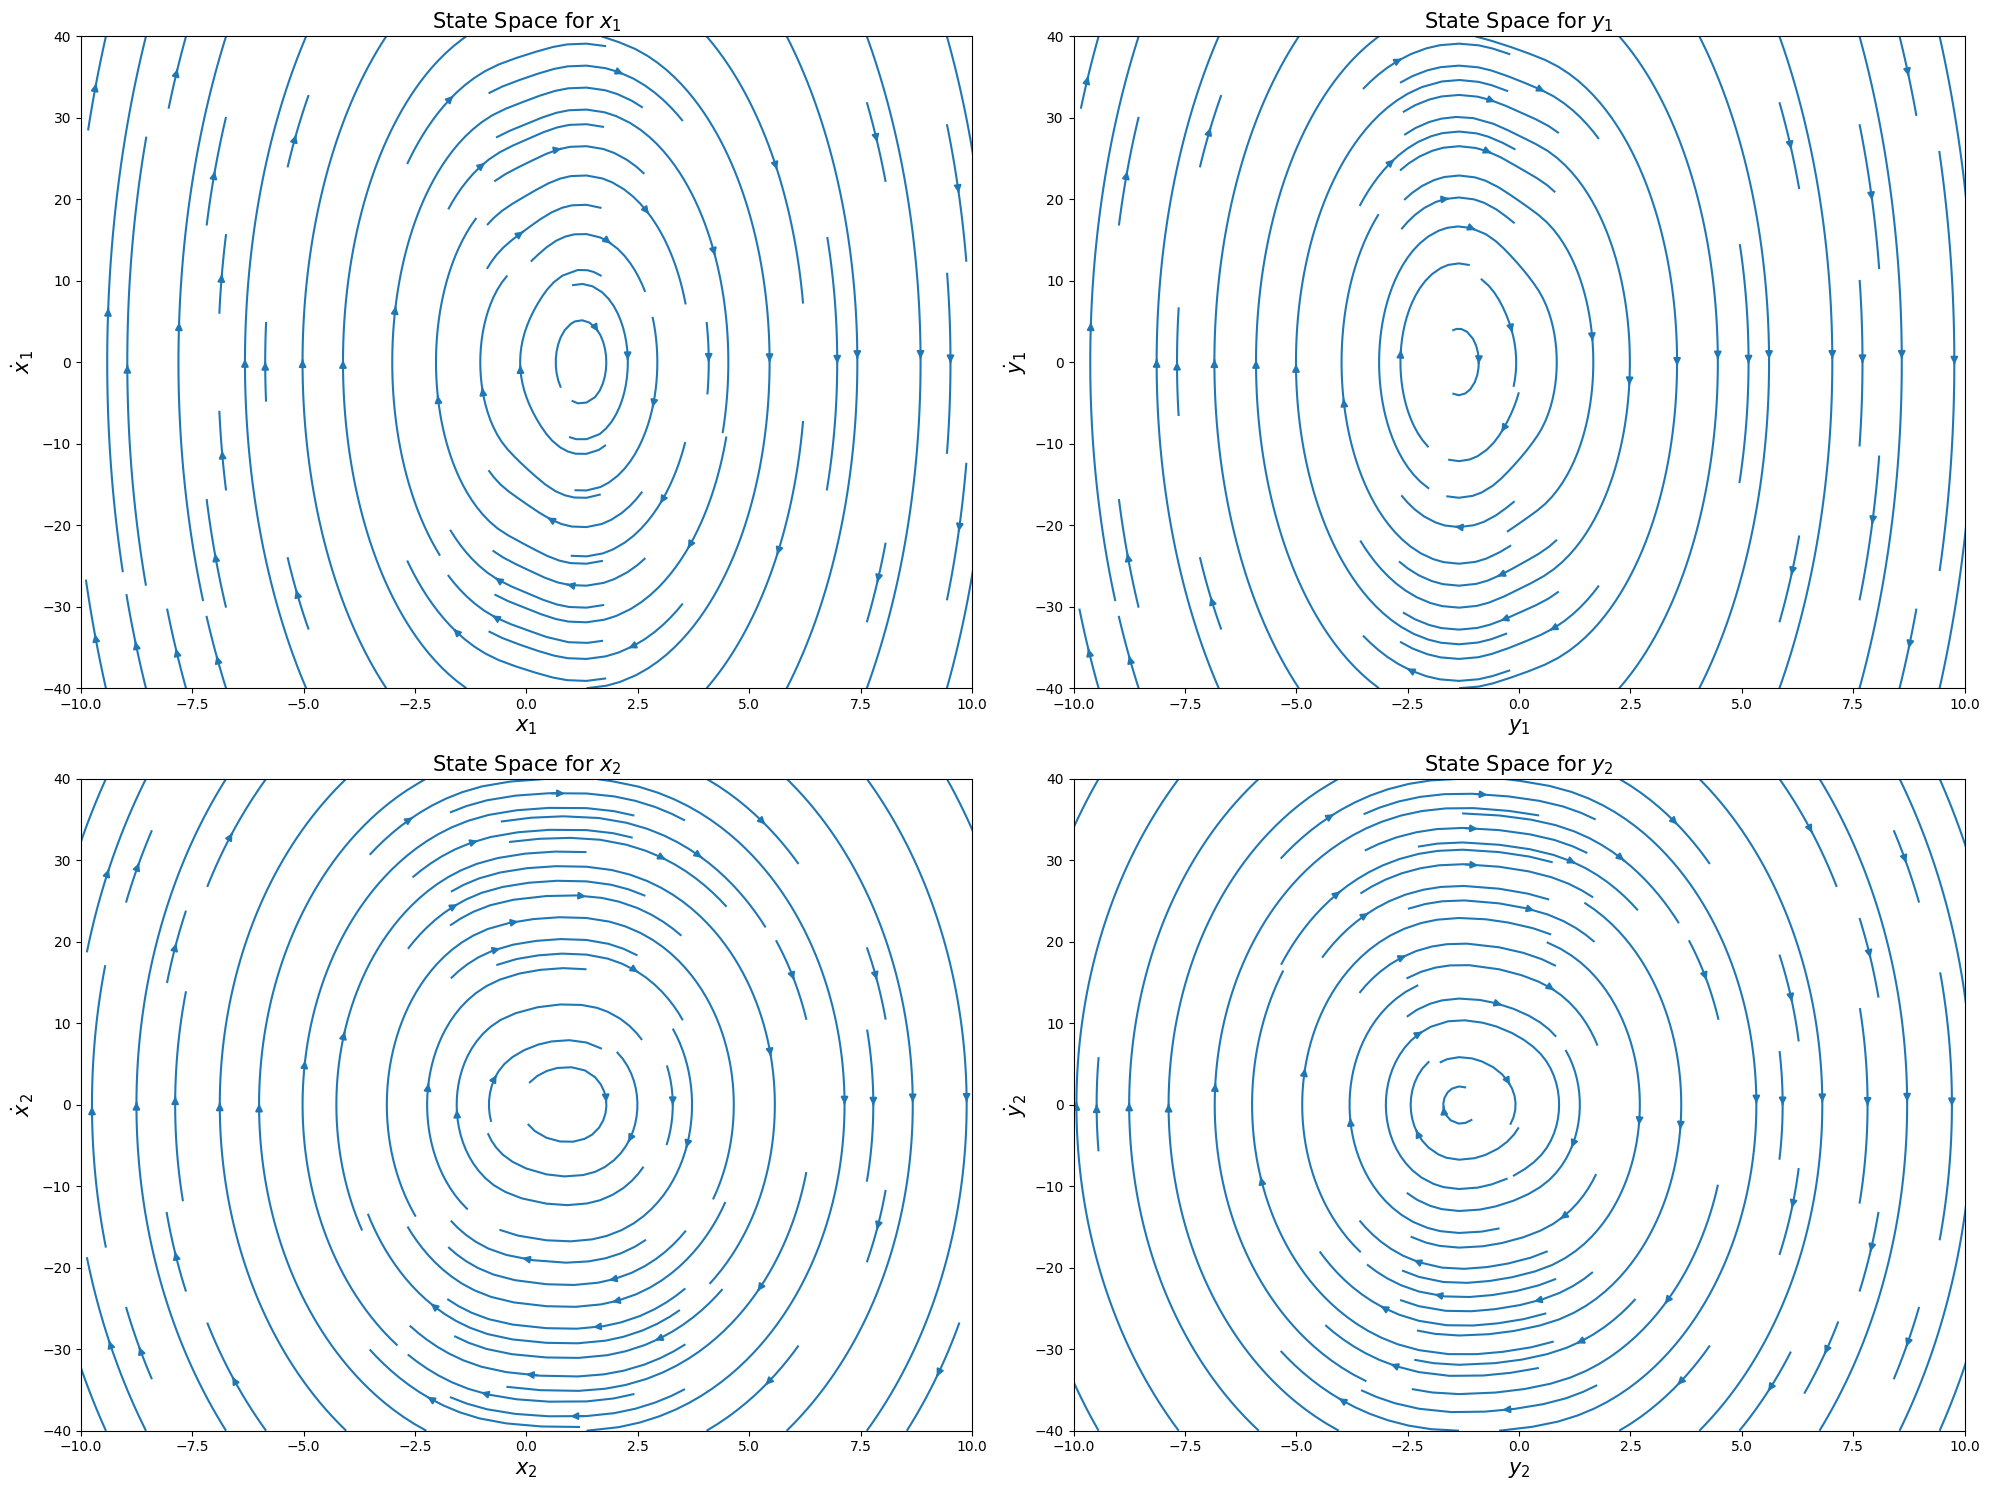

In [ ]:
fig = plt.figure(figsize=(20, 15))

streamplot_state_spaces(spring_pendulum, fig)

fig.savefig("something.png", bbox_inches='tight')